In [1]:
#A continuación importamos las librerias que utilizaremos. 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
import time
import matplotlib.animation as animation

# Final: Métodos Computacionales
### Estudiantes: Andrés Hernández (201329363)    Francisco Díaz (201912252)
## 1. 2D Navier-Stokes simulation

In [2]:
# Definimos la clase correspondiente al sistema de la simulación

class NavierStokes:
    def __init__(self, V0_ = 1.0, v_ = 0.2, h_ = 0.02, Xmax_ = 50, Ymax_ = 50, BGeom_ = [5,20,5,30]):
        
        # My constants
        self.V0, self.v = V0_, v_
        self.h, self.omega = h_, 0.7
        self.Xmax, self.Ymax = Xmax_ , Ymax_
        self.U = np.zeros((Xmax_+1, Ymax_+1))
        self.W = np.zeros((Xmax_+1, Ymax_+1))
        self.BGeom = BGeom_
        
    def evolution(self, MaxIter):
        Ut = np.zeros((MaxIter,self.Xmax+1, self.Ymax+1))
        Wt = np.zeros((MaxIter,self.Xmax+1, self.Ymax+1))
        # Volume boundaries
        self.limits()
        
        # System evolution
        for i in tqdm(range(MaxIter)):
            Ut[i] = self.U
            Wt[i] = self.W
            self.update()
                  
        return Ut, Wt    
                   
    def limits(self):
        
        # Start stream
        for i in range(self.Xmax+1):
            for j in range(self.Ymax+1):
                self.U[i,j]= j*self.V0
                
        # Upper limit
        for i in range(self.Xmax+1):
            self.U[i,Ymax] = self.U[i,Ymax-1] + self.V0*self.h
            self.W[i,Ymax-1] = 0.
            
        # Left limit 
        for j in range(self.Ymax+1):
            self.U[1,j] = self.U[0,j]
            self.W[0,j] = 0.        
            
        # Lower limit
        for i in range(self.Xmax+1):
                self.U[i,0] = 0.
                self.W[i,0] = 0.
                
        # Right limit
        for j in range(1, self.Ymax):
            self.W[self.Xmax,j] =self.W[self.Xmax-1,j] 
            self.U[self.Xmax,j] =self.U[self.Xmax-1,j]
        
    
    def beam(self):
        
        # Voriticity boundaries
        ## Horizontal limits
        for j in range(self.BGeom[2], self.BGeom[2]+self.BGeom[3]+1):
            self.W[self.BGeom[0],j] = -2*(self.U[self.BGeom[0]-1,j]-self.U[self.BGeom[0],j])/(h**2)
            self.W[self.BGeom[0]+self.BGeom[1],j] =-2*(self.U[self.BGeom[0]+self.BGeom[1]+1,j]- self.U[self.BGeom[0]+self.BGeom[1],j])/(h**2)
        
        ## Vertical limits
        for i in range(self.BGeom[0], self.BGeom[0]+self.BGeom[1]+1):
            self.W[i,self.BGeom[2]] = -2*(self.U[i,self.BGeom[2]-1]-self.U[i,self.BGeom[2]])/(h**2)
            self.W[i,self.BGeom[2]+self.BGeom[3]] = -2*(self.U[i,self.BGeom[2]+self.BGeom[3]+1] - self.U[i,self.BGeom[2]+self.BGeom[3]])/(h**2)
        
        # Stream boundaries
        for i in range(self.BGeom[0], self.BGeom[0]+self.BGeom[1]+1):
            for j in range(self.BGeom[2], self.BGeom[2]+self.BGeom[3]+1):
                self.U[self.BGeom[0],j] = 0.
                self.U[self.BGeom[0]+self.BGeom[1],j] = 0.
                self.U[i,self.BGeom[2]] = 0.
                self.U[i, self.BGeom[2]+self.BGeom[3]] = 0.
        
        # Stream and vorticity inside beam
        for i in range(self.BGeom[0]+1, self.BGeom[0]+self.BGeom[1]):
            for j in range(self.BGeom[2]+1, self.BGeom[2]+self.BGeom[3]):
                self.U[i,j] = 0.
                self.W[i,j] = 0.
                
    def update(self):
        
        # Reynolds number
        R = self.V0*self.h/self.v
    
        # Stream evolution
        for i in range(1, self.Xmax):
            for j in range(1, self.Ymax):
                u = self.omega*((self.U[i+1,j] +self.U[i-1,j]+ self.U[i,j+1] \
                    +self.U[i,j-1]+ (self.h**2)*self.W[i,j])*(0.25) -self.U[i,j])
                self.U[i,j] += u
        
        # Vorticity evolution
        for i in range(1, self.Xmax-1):
            for j in range(1, self.Ymax-1):
                w = ((self.W[i+1,j] +self.W[i-1,j]+ self.W[i,j+1]+ self.W[i,j-1] \
                    -(R/4.)*((self.U[i,j+1] -self.U[i,j-1])*(self.W[i+1,j] -self.W[i-1,j]) \
                    - (self.U[i+1,j] -self.U[i-1,j])*(self.W[i,j+1] -self.W[i,j-1])))/4.  \
                    - self.W[i,j])
                self.W[i,j] += self.omega*w
                
        # Beam boundaries     
        self.beam()                 

In [3]:
# Definimos nuestras constante e iniciamos nuestro sistema

V0,v = 1., 0.2
Xmax, Ymax = 50, 50
h = 0.02
tmax = 500 # Número de iteraciones máximas, para la animación del vínculo se utilizaron 500
Sistema = NavierStokes(V0,v, h, Xmax, Ymax, [5,20,5,25])
U, W = Sistema.evolution(tmax)

100%|██████████| 500/500 [00:23<00:00, 20.87it/s]


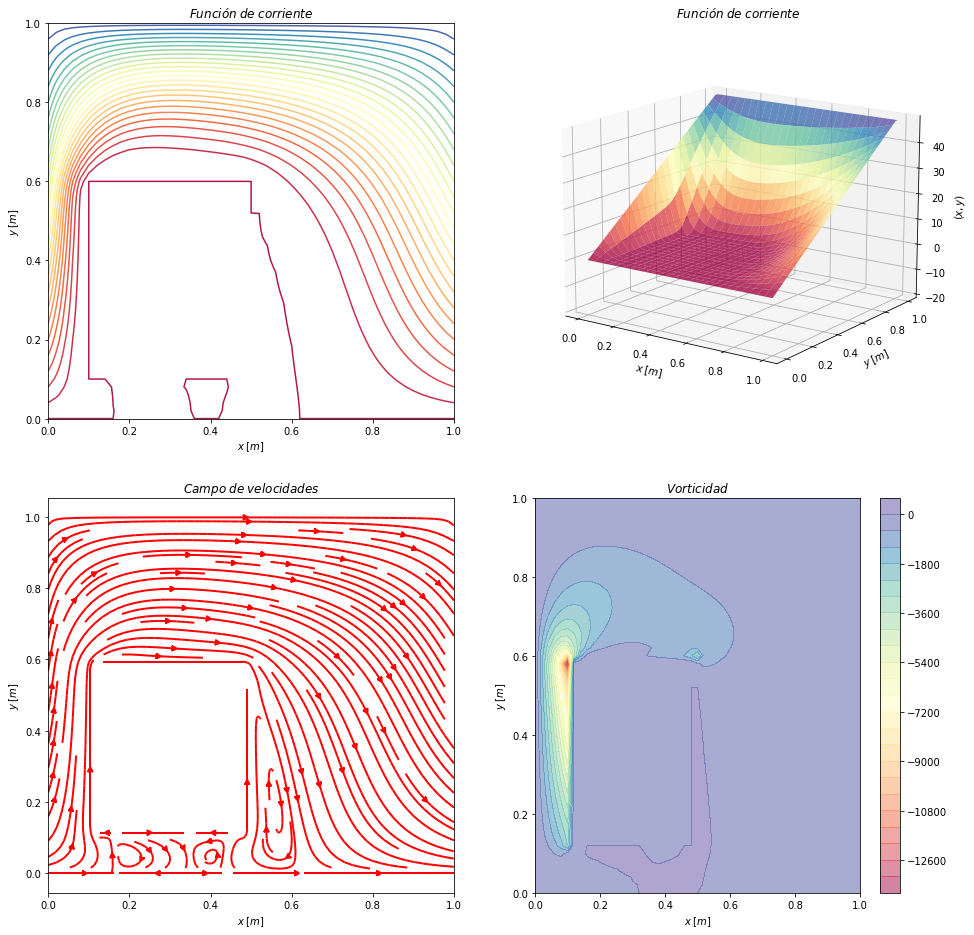

In [4]:
# Ahora graficamos 

x = np.linspace(0,1,Xmax+1)
y = np.linspace(0,1, Ymax+1)
X,Y = np.meshgrid(x,y)
ux, uy = np.gradient((U[-1,:,:]))

fig=plt.figure(figsize=(16,16))

ax= fig.add_subplot(2,2,1)
ax.contour(X,Y, np.transpose(U[-1,:,:]), levels = 25 , cmap = cm.Spectral)
ax.set_xlabel('$x \; [m]$')
ax.set_ylabel('$y \; [m]$')
ax.set_title('$Función \; de \; corriente$')

ax = fig.add_subplot(222, projection='3d')
ax.view_init(elev=15, azim = -55)
ax.plot_surface(X, Y, np.transpose(U[-1,:,:]),  cmap = cm.Spectral, alpha=0.8)
ax.set_zlim(-20, np.max(U[-1,:,:]))
ax.set_xlabel('$x \; [m]$')
ax.set_ylabel('$y \; [m]$')
ax.set_zlabel('$(x,y)$')
ax.set_title('$Función \; de \; corriente$')

ax= fig.add_subplot(2,2,3)
ax.streamplot(X,Y,np.transpose(uy), np.transpose(-ux), density = 1.5, arrowstyle = 'fancy', linewidth=2, color = 'r')
ax.set_xlabel('$x \; [m]$')
ax.set_ylabel('$y \; [m]$')
ax.set_title('$Campo \; de \; velocidades$')

ax= fig.add_subplot(2,2,4)
surf = ax.contourf(X,Y, np.transpose(W[-1,:,:]), levels = 25, cmap = cm.Spectral, alpha  = 0.5 , vmin= np.min(W[-1,:,:]), vmax=np.max(W[-1,:,:])*0.2)
ax.set_xlabel('$x \; [m]$')
ax.set_ylabel('$y \; [m]$')
ax.set_title('$Vorticidad$')
plt.colorbar(surf)

plt.show()

**NOTA:** A continuación generamos una pequeña animación de la evolución del sistema a lo largo del tiempo para 500 iteraciones. No obstante, la generación de está tarda un poco ( alrdededor de 5 min en mi PC). Por este motivo la generamos una única vez y la subimos a YouTube. A continuación se adjunta el vinculo del vídeo:
https://youtu.be/w7BC7BEcPAQ

In [5]:
# Generamos una pequeña animación de las gráficas anteriores a lo largo del tiempo
t = np.linspace(0, tmax*h, tmax)
def update_plot(i,X,Y,U, ax1, ax2):
    ax1.clear(), ax2.clear()
    
    ax1.contour(X,Y, np.transpose(U[i,:,:]), levels = 25 , cmap = cm.Spectral)
    ax1.set_xlabel('$x \; [m]$')
    ax1.set_ylabel('$y \; [m]$')
    ax1.set_title('$Función \; de \; corriente$ \n'+ '$ [t = {:.2f} ]$'.format(t[i]), fontsize=10)
    
    ax2.contourf(X,Y, np.transpose(W[i,:,:]), levels = 35, cmap = cm.Spectral, alpha  = 0.5 , vmin= np.min(W[-1,:,:]), vmax=np.max(W[-1,:,:])*0.2)
    ax2.set_xlabel('$x \; [m]$')
    ax2.set_ylabel('$y \; [m]$')
    ax2.set_title('$Vorticidad $ \n'+ '$[t = {:.2f} ]$'.format(t[i]), fontsize=10)
    
def crear_animacion(X,Y,U,name):
    N = U.shape[0]
    fig=plt.figure(figsize=(16,8), dpi = 150)
    ax1= fig.add_subplot(1,2,1)
    ax2= fig.add_subplot(1,2,2)

    plt.title("$Time = 0.0$", fontsize=10) 
    ani = animation.FuncAnimation(fig, update_plot, range(1,N), fargs=(X,Y,U,ax1, ax2))
    ani.save(name,fps=24)
    plt.close(fig)

start_time = time.time()
crear_animacion(X,Y,U,'NavierStokes.mp4')
print("Tiempo usado en crear la animación (s):", time.time() - start_time)

Tiempo usado en crear la animación (s): 424.9922847747803
